### Task 1: Classifying "Good" vs. "Bad" Tracks

In [1]:
import os
import sys
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import joblib
import torch.nn.init as init
import seaborn as sns

from torch.utils.data import WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
from torch.autograd import Variable
from sklearn.model_selection import StratifiedKFold

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "/home/gridsan/dzhao/ManeuverID_shared/dan_zhao/Task_1/path_imgdata/"

#### Image pre-processing and data setup

In [3]:
def customcrop(image):
    return transforms.functional.crop(image, 70, 155, 700, 875)

In [4]:
data_transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((50, 50)),
    transforms.Lambda(customcrop),
    transforms.Resize((100,125)),
    transforms.ToTensor()]
)
dataset = torchvision.datasets.ImageFolder(root_dir, transform=data_transform)

In [5]:
total_n = len(dataset)
train_n = int(0.8 * total_n)
test_n = total_n - train_n

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_n, test_n)
)

In [6]:
train_dataset.dataset.class_to_idx

{'bad': 0, 'good': 1}

In [7]:
y_trnidx = train_dataset.indices
y_trn = [dataset.targets[i] for i in y_trnidx]
class_n = np.array([np.sum(y_trn == c) for c in np.unique(y_trn)])

In [8]:
y_tstidx = test_dataset.indices
y_tst = [dataset.targets[i] for i in y_tstidx]
class_n_tst = np.array([np.sum(y_tst == c) for c in np.unique(y_tst)])

In [14]:
print(class_n, class_n_tst)

[ 267 1929] [ 75 475]


In [15]:
### optional sampling of data, not necessary
# weight = 1. / class_n
# samples_weight = np.array([weight[t] for t in y_trn])
# samples_weight = torch.from_numpy(samples_weight)
# smplr = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=8, num_workers=2, pin_memory=True, sampler=smplr
#     )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, num_workers=2, shuffle=True, pin_memory=True
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True
)

#### Example of a flight path/track

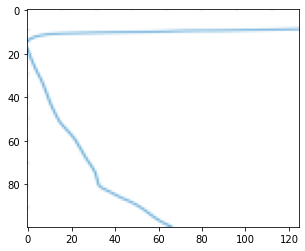

In [16]:
plt.imshow((next(iter(train_loader))[0][0]).permute(1, 2, 0))
plt.show()

#### Defining the model

In [17]:
model = models.resnet50(pretrained=False)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=2048, out_features=2)
model = model.to(device)

In [18]:
model.fc

Linear(in_features=2048, out_features=2, bias=True)

In [19]:
n_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

In [20]:
def test(loader, criterion):
    model.eval()
    running_loss = 0.
    total = 0
    correct = 0

    for images,labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            pred = model(images)
            loss = criterion(pred, labels)
            
        running_loss += loss
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        
    val_acc = correct/total
    val_loss = running_loss/len(loader)
    model.train()
    
    return val_acc, val_loss

#### Training the model

In [21]:
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

for epoch in range(n_epochs):
    loss_avg = 0.
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader)
    for i, (images,labels) in enumerate(progress_bar):
        progress_bar.set_description("Epoch " + str(epoch))
        images = images.to(device)
        labels = labels.to(device)
        
        pred = model(images)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_avg += loss.item()
        
        pred1 = torch.max(pred.data,1)[1]
        total += labels.size()[0]
        correct += (pred1 == labels.data).sum().item()
        accuracy = correct/total
        
        progress_bar.set_postfix(acc=accuracy)
    
    trn_losses.append(loss_avg/i)
    trn_accs.append(accuracy)
    
    test_acc, test_loss = test(test_loader, criterion)
    val_accs.append(test_acc)
    val_losses.append(test_loss)
    tqdm.write("test_acc: %.3f" % test_acc)    

  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.138


  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.949


  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.962


  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.965


  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.958


  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.973


  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.971


  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.962


  0%|          | 0/69 [00:00<?, ?it/s]

test_acc: 0.973


Epoch 9: 100%|██████████| 69/69 [00:17<00:00,  3.93it/s, acc=0.982]


test_acc: 0.978


In [22]:
# model = models.resnet50(pretrained=False)
# model = model.to(device)
# model.load_state_dict(torch.load("visual_only_resnet50.pth"))
model.eval()

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True
)

correct_pos = 0
wrong_pos = 0
correct_neg = 0
wrong_neg = 0
totright = 0
for i, (images,labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        pred = model(images)
        pred1 = torch.max(pred.data,1)[1]
        right = (pred1 == labels.data).sum().item()        
        
        if labels.item() == 1 and right == 1:
            correct_pos += 1
        elif labels.item() == 1 and right == 0:
            wrong_neg += 1
        elif labels.item() == 0 and right == 1:
            correct_neg += 1
        elif labels.item() == 0 and right == 0:
            wrong_pos += 1
            
        totright += right

In [26]:
print(correct_pos/class_n_tst[1], correct_neg/class_n_tst[0])

0.9852631578947368 0.9333333333333333


In [24]:
print(correct_pos, wrong_neg, correct_neg, wrong_pos, totright)

468 7 70 5 538


In [54]:
class_n_tst

array([ 68, 482])

#### Saving the end model and its weights

In [25]:
torch.save(model.state_dict(), "visual_only_resnet50.pth")